# Visual Odometry
This notebook apply stereo depth estimation and multiple view geometry to track vehicle position through a sequencee of the images from kitti dataset.

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from dataclasses import dataclass

_ = load_dotenv()

True

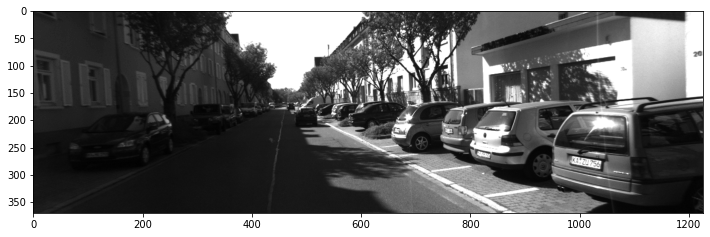

In [6]:
l_image_dir: list[str] = sorted(os.listdir(os.getenv("l_image_dir")), key=lambda x: int(x.strip('.')[0]))
len(l_image_dir)

image = plt.imread(os.path.join(os.getenv("l_image_dir"), l_image_dir[763]))
plt.figure(figsize=(12, 6))
plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
from typing import Iterator, Optional


class DatasetHandler(object):
    def __init__(self) -> None:
        self.l_dr = os.getenv("l_image_dir")
        self.r_dr = os.getenv("r_image_dir")
        self.l_ls = sorted(os.listdir(self.l_dr), key=lambda x: int(x.split('.')[0]))
        self.r_ls = sorted(os.listdir(self.r_dr), key=lambda x: int(x.split('.')[0]))
        self._reset_frame()
        
        # Ground truth
        p = pd.read_csv(os.getenv("poses_file"), delimiter=' ', header=None)
        self.gt: np.ndarray = p.values.reshape((-1, 3, 4))

        # Camera intrinsic matrix, and lidar transform matrix
        c = pd.read_csv(os.getenv("calib_file"), delimiter=' ', header=None, index_col=0)
        self.K0, self.K1, self.Tr = map(
            lambda x: np.array(c.loc[x, :]).reshape((3, 4)), ('P0:', 'P1:', 'Tr:')
        )

        self.frame_num: int = len(self.l_ls)
        self.frame_idx: int = 1
        self.l_image_1: cv2.Mat = next(self.l_images)


    def frame(self) -> tuple:
        pass

    def next_frame(self) -> None:
        self.l_image_0 = self.l_image_1
        self.r_image_0 = next(self.r_images)
        self.l_image_1 = next(self.l_images)

        self.lidar_t = next(self.lidar)
    
    def stop(self) -> bool:
        return self.frame_num == self.frame_idx
    
    def imsize(self) -> tuple[int, int]:
        return self.l_image_1.shape[0], self.l_image_1.shape[1]

    def _reset_frame(self) -> None:
        self.l_images: Iterator[cv2.Mat] = (
            cv2.imread(os.path.join(self.l_dr, file)) 
            for file in self.l_ls
        )
        self.r_images: Iterator[cv2.Mat] = (
            cv2.imread(os.path.join(self.r_dr, file)) 
            for file in self.r_ls
        )
        self.lidar: Iterator[np.ndarray] = (
            np.fromfile(os.path.join("folder_path", file))
            for file in self._ls
        )

In [ ]:
class Config(object):
    depth: bool
    lidar_correct: bool
    stereo_matcher: str = 'e'



class VisualOdometry(object):
    def __init__(self, config: Config) -> None:
        self.config: Config = config

        self.T: np.ndarray = np.eye(4)
        self.traj: np.ndarray = np.zeros((handler.frame_num, 3, 4))
        self.traj[0] = self.T[:3, :]

    def update(
        self,
        imgl0: np.ndarray[np.uint8],
        imgr0: np.ndarray[np.uint8],
        imgl1: np.ndarray[np.uint8],
        pc0: Optional[np.ndarray[np.float32]] = None
    ) -> None:
        """ Update frame `t` data include images and point cloud map to the odometry
        @param imgl0: image in time `t` of camera 0
        @param imgr0: image in time `t` of camera 1
        @param imgl1: image in time `t+1` of camera 0
        @param pc0: point cloud map in time `t`
        """
        depth: Optional[np.ndarray] = None
        if self.config.depth:
            depth: np.ndarray = self._depth_estimate(imgl0, imgr0, pc0)
        
        m, kp0, kp1 = self._matched_features(imgl0, imgl1)

        R, t = self._motion_estimate(m, kp0, kp1, depth)

        T_t = np.eye(4)
        

        


    def _depth_estimate(self, image0, image1, pcl) -> np.ndarray:
        
        ## stero depth estimation
        depth: np.ndarray = np.array(1)

        ## lidar correction
        if not self.config.lidar_correct:
            return depth
        


    def _matched_features(self, image0, image1) -> tuple[list[cv2.DMatch], list[cv2.KeyPoint], list[cv2.KeyPoint]]:
        pass

    def _motion_estimate(
        self, 
        matches: list[cv2.DMatch],
        kp1: list[cv2.KeyPoint],
        kp2: list[cv2.KeyPoint],
        depth: Optional[np.ndarray] = None
    ) -> tuple[np.ndarray]:
        R: np.ndarray = np.eye(3)
        t: np.ndarray = np.zeros((3, 1))

        img1_pts = np.float32([kp1[m.queryIdx].pt for m in matches])

In [ ]:
from tqdm import tqdm

def main() -> VisualOdometry:
    
    handler = DatasetHandler()
    vo = VisualOdometry()

    h, w = handler.imsize()

    

    for i in tqdm(range(handler.frame_num - 1)):
        i00, i01, i10, l0 = handler.next_frame()

        vo.update(i00, i01, i10, l0)


In [ ]:
class VisualOdometry(object):
    def __init__(self) -> None:
        pass

    def update(self) -> None:
        pass

    def _features_manipulate(self) -> None:
        pass

    def _depth_estimate(self) -> None:
        pass

    def _motion_estimate(self, match: list[cv2.DMatch], kp0: list[cv2.KeyPoint], kp1: list[cv2.KeyPoint], depth: np.ndarray = None) -> tuple:
        R: np.ndarray = np.eye(3)
        t: np.ndarray = np.zeros((3, 1))

        image0_pts = np.float32([kp0[m.queryIdx].pt for m in match])
        image1_pts = np.float32([kp1[m.trainIdx].pt for m in match])

        if depth is None: # apply essential matrix decomposition, scale ambiguous
            E = cv2.findEssentialMat(image0_pts, image1_pts, self.K)[0]
            _, R, t, _ = cv2.recoverPose(E, image0_pts, image1_pts, self.K)
            return R, t, image0_pts, image1_pts
        
